# FeathersV1 Classification

Jupyter Notebook for FeathersV1 Dataset.

See more at:

* [FeathersV1 Dataset](https://github.com/feathers-dataset/feathersv1-dataset)
* [FeathersV1 Classification](https://github.com/feathers-dataset/feathersv1-classification)
* [Feathers dataset for Fine-Grained Visual Categorization](https://arxiv.org/abs/2004.08606)

# 1. Init project

In [149]:
import importlib
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
from sklearn.utils import class_weight

SEED = 42
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

print("TensorFlow version:", tf.__version__)
print("Num CPUs: ", len(tf.config.experimental.list_physical_devices("CPU")))
print("Num GPUs: ", len(tf.config.experimental.list_physical_devices("GPU")))
print("Num TPUs: ", len(tf.config.experimental.list_physical_devices("TPU")))

!python3 --version

%matplotlib inline

TensorFlow version: 2.3.0
Num CPUs:  1
Num GPUs:  1
Num TPUs:  0
Python 3.6.9


## Setup project

In [150]:
# Path for FeathersV1 Dataset.
# https://github.com/feathers-dataset/feathersv1-dataset

DATASET_DIR = Path(".") / "feathersv1-dataset"

# Type of neural network model.
# Currently we support only Keras models from https://keras.io/applications

MODEL_TYPE = "DenseNet201"

# Count of classes to predict.
# Please select `top_50`, `top_100` or `all` classes count.

CLASSES_COUNT = "top_100"

# Directory name for save model weights and history CSV file.
# The model will be saved to the `result/PROJECT_NAME` folder.

PROJECT_NAME = f"{MODEL_TYPE}_{CLASSES_COUNT}"

# Set CSV data paths.
# These paths are automatically generated based on previous configs.

TRAIN_CSV = DATASET_DIR / "data" / f"train_{CLASSES_COUNT}_species.csv"
TEST_CSV = DATASET_DIR / "data" / f"test_{CLASSES_COUNT}_species.csv"

## Set training parameters

In [151]:
# Resize loaded images to this size.
IMG_WIDTH, IMG_HEIGHT = 240, 40

# Model parameters.
BATCH_SIZE = 64
EPOCHS = 16

# 2. Load data

## Define CSV loading functions

In [152]:
def csv_to_paths(dataset_dir, csv_file):
    with open(csv_file, "r") as readfile:
        readfile.readline()  # skip header

        csv_data = readfile.readlines()

    image_paths = []

    for line in csv_data:
        image_path_parts = [
            x.lower().replace(" ", "_") for x in line.strip().split(",")
        ]

        image_path = (
            dataset_dir
            / "images"
            / image_path_parts[1]
            / image_path_parts[2]
            / image_path_parts[0]
        )

        image_paths.append(image_path.as_posix())

    return image_paths


def read_labels(file_path, label_type):
    # Select position of label in CSV file by type.
    if label_type == "order":
        pos = 1
    elif label_type == "species":
        pos = 2
    else:
        raise Exception("undefined label type")

    # Return classes from CSV file.
    with open(file_path, "r") as readfile:
        readfile.readline()  # skip header
        return [line.strip().split(",")[pos] for line in readfile.readlines()]

## Define images processing and augmentation

In [153]:
def augment(img):
    img = tf.image.random_brightness(img, max_delta=0.15, seed=SEED)
    img = tf.image.random_saturation(img, lower=0.80, upper=1.20, seed=SEED)
    img = tf.image.random_contrast(img, lower=0.80, upper=1.20, seed=SEED)
    img = tf.image.random_flip_left_right(img, seed=SEED)

    return img


def process_image(file_path):
    # Load the raw data from the file as a string.
    img = tf.io.read_file(file_path)

    # Convert the compressed string to a 3D uint8 tensor.
    img = tf.image.decode_jpeg(img, channels=3)

    # Rotate if width > height.
    if tf.shape(img)[1] > tf.shape(img)[0]:
        img = tf.image.rot90(img, k=1)

    # Apply augmentation.
    img = augment(img)

    # Use `convert_image_dtype` to convert to floats in the [0, 1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

## Load images to TensorFlow datasets

In [154]:
X_train = tf.data.Dataset.from_tensor_slices(
    csv_to_paths(DATASET_DIR, TRAIN_CSV)
).map(process_image)

X_test = tf.data.Dataset.from_tensor_slices(
    csv_to_paths(DATASET_DIR, TEST_CSV)
).map(process_image)

## Load labels

In [155]:
y_train_labels = read_labels(TRAIN_CSV, label_type="species")
y_test_labels = read_labels(TEST_CSV, label_type="species")

## Encode labels

In [156]:
enc = LabelEncoder()
_ = enc.fit(list({*y_train_labels, *y_test_labels}))

y_train_labels = enc.transform(y_train_labels)
y_test_labels = enc.transform(y_test_labels)

## Add class weights to balance classes

In [157]:
def count_weight(num_samples):
  return df.count() / (df['species'].nunique() * num_samples)

df = pd.read_csv(TRAIN_CSV)
df = df.apply(LabelEncoder().fit_transform)
weights = df['species'].value_counts().apply(lambda x: count_weight(x))
class_weights = weights['species'].to_dict()
print(class_weights)

{1: 0.23953907815631262, 62: 0.32045576407506704, 0: 0.3415142857142857, 45: 0.42537366548042704, 44: 0.45622137404580154, 28: 0.48392712550607286, 60: 0.48589430894308944, 8: 0.5022268907563026, 48: 0.5585514018691589, 49: 0.5585514018691589, 54: 0.5638207547169811, 39: 0.6006532663316583, 9: 0.6006532663316583, 89: 0.6426344086021505, 40: 0.6990058479532164, 10: 0.7031176470588235, 29: 0.7244242424242424, 71: 0.7424223602484472, 35: 0.7517610062893082, 43: 0.7613375796178344, 87: 0.7761688311688312, 22: 0.7761688311688312, 16: 0.79158940397351, 12: 0.8022147651006711, 83: 0.8131292517006803, 15: 0.8358741258741259, 14: 0.8417605633802817, 76: 0.8537857142857143, 27: 0.8537857142857143, 68: 0.8920149253731343, 99: 0.9486507936507936, 42: 0.9717886178861789, 82: 1.0129661016949152, 4: 1.0216239316239317, 5: 1.0304310344827585, 11: 1.057787610619469, 3: 1.067232142857143, 96: 1.0966055045871559, 97: 1.1171028037383177, 33: 1.1276415094339622, 19: 1.149326923076923, 30: 1.160485436893203

## Move encoded labels to TensorFlow datasets

In [158]:
y_train = tf.data.Dataset.from_tensor_slices(y_train_labels)
y_test = tf.data.Dataset.from_tensor_slices(y_test_labels)

## Join images and labels

In [159]:
train_dataset = (
    tf.data.Dataset.zip((X_train, y_train)).repeat().batch(BATCH_SIZE)
)

test_dataset = tf.data.Dataset.zip((X_test, y_test)).batch(BATCH_SIZE)

## Plot train batch

In [160]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(14, 10))
    rows = 2
    cols = 6

    for n in range(cols * rows):
        _ = plt.subplot(rows, cols, n + 1)
        plt.imshow(image_batch[n])
        plt.title(enc.classes_[label_batch[n]])

    plt.show()

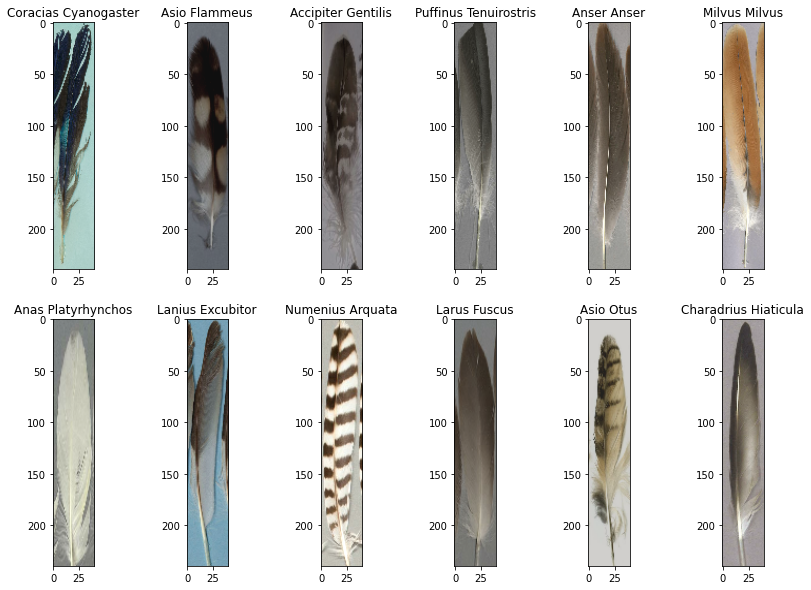

In [161]:
image_batch, label_batch = next(iter(train_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

# 3. Train model

In [ ]:
(Path("results") / PROJECT_NAME).mkdir(parents=True, exist_ok=True)

# Metrics.
metric_sparse_top_1 = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=1, name="sparse_top_1_categorical_accuracy", dtype=None
)

metric_sparse_top_5 = tf.keras.metrics.SparseTopKCategoricalAccuracy(
    k=5, name="sparse_top_5_categorical_accuracy", dtype=None
)

# Callbacks.
callback_save_best_weights = tf.keras.callbacks.ModelCheckpoint(
    filepath=f"results/{PROJECT_NAME}/weights.hdf5",
    monitor="val_sparse_top_5_categorical_accuracy",
    mode="max",
    save_best_only=True,
    verbose=0,
)

callback_csv_logger = tf.keras.callbacks.CSVLogger(
    filename=f"results/{PROJECT_NAME}/training.csv",
    separator=",",
    append=False,
)

# Model.
model_object = getattr(
    importlib.import_module("tensorflow.keras.applications"), MODEL_TYPE,
)

model = model_object(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    classes=len(enc.classes_),
    weights=None,
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[metric_sparse_top_1, metric_sparse_top_5],
)

print("Total {} classes".format(len(enc.classes_)))

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=EPOCHS,
    class_weight=class_weights,
    steps_per_epoch=len(y_train_labels) // BATCH_SIZE,
    callbacks=[callback_save_best_weights, callback_csv_logger],
)

## Plot history

In [ ]:
def plot_history(metrics):
    plt.figure(figsize=(12, 10))

    colors = iter(["r", "b", "g"])

    axes = [
        plt.subplot2grid((2, 2), (0, 0)),
        plt.subplot2grid((2, 2), (0, 1)),
        plt.subplot2grid((2, 2), (1, 0), colspan=2),
    ]

    for plots in zip(axes, reversed(metrics)):
        ax, metric = plots

        ax.plot(
            history.history[metric], c=next(colors), marker="x", linewidth=1.8,
        )

        ax.set_xlabel("epoch")
        ax.set_ylabel("value")
        ax.set_title(metric)
        ax.grid()

    plt.show()

## Plot train history

In [ ]:
metrics_names = [
    "loss",
    "sparse_top_1_categorical_accuracy",
    "sparse_top_5_categorical_accuracy",
]

plot_history(metrics_names)

## Plot validation history

In [ ]:
metrics_names = [
    "val_loss",
    "val_sparse_top_1_categorical_accuracy",
    "val_sparse_top_5_categorical_accuracy",
]

plot_history(metrics_names)

## Reload model object with best weights

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

model_object = getattr(
    importlib.import_module("tensorflow.keras.applications"), MODEL_TYPE,
)

model = model_object(
    input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    classes=len(enc.classes_),
    weights=f"results/{PROJECT_NAME}/weights.hdf5",
)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[metric_sparse_top_1, metric_sparse_top_5],
)

## Evaluate model

In [ ]:
evaluate = model.evaluate(test_dataset)

In [ ]:
print(tabulate(zip(model.metrics_names, evaluate)))

## Make prediction

In [ ]:
predict_dataset = model.predict(test_dataset)

## Plot prediction batch

In [ ]:
test_image_batch, test_label_batch = next(iter(test_dataset))
show_batch(test_image_batch, test_label_batch)

## Plot predicted classes probability

In [ ]:
plots_count = 5
top_classes_count = 5


def get_top_predict(predict_dataset, top_count):
    # Get all class names by order.
    classes_names = enc.inverse_transform(
        [x for x in range(len(predict_dataset))]
    )

    # Zip all classes and its probabilities.
    class_and_prob = list(zip(classes_names, predict_dataset))

    # Sort list by probability.
    top_classes = sorted(class_and_prob, key=lambda x: x[1], reverse=True)

    # Return top_count classes.
    return top_classes[:top_count]


_, plt_arr = plt.subplots(plots_count, 2, figsize=(10, 14))

data = [
    get_top_predict(predict_element, top_classes_count)
    for predict_element in predict_dataset[:plots_count]
]

for i in range(plots_count):
    # Plot image.
    plt_arr[i][0].imshow(test_image_batch[i])
    plt_arr[i][0].set_ylabel(enc.classes_[test_label_batch[i]])

    # Plot barchart probabilities.
    barh_probs = list(reversed([x[1] for x in data[i]]))  # probabilities
    barh_ticks = list(reversed([x[0] for x in data[i]]))  # classes

    plt_arr[i][1].barh(
        y=[n for n in range(top_classes_count)],
        width=barh_probs,
        tick_label=barh_ticks,
    )

    plt_arr[i][1].grid(color="#0c0c0c", linestyle="-", linewidth=0.2)
    plt_arr[i][1].set_xlim(0.0, 1.0)

plt.show()

## Plot classification heatmap

In [ ]:
y_pred_labels = np.argmax(predict_dataset, axis=1)

fig, ax = plt.subplots(figsize=(16, 14))

conf_matrix = tf.math.confusion_matrix(y_test_labels, y_pred_labels)

annot = enc.inverse_transform([x for x in range(len(enc.classes_))])

if CLASSES_COUNT == "top_50":
    plot = sns.heatmap(
        conf_matrix, cmap="coolwarm", xticklabels=annot, yticklabels=annot
    ).get_figure()
else:
    plot = sns.heatmap(conf_matrix, cmap="coolwarm").get_figure()

## Compute additional metrics

In [ ]:
print(
    "F1 score micro:", f1_score(y_test_labels, y_pred_labels, average="micro")
)

print(
    "F1 score macro:", f1_score(y_test_labels, y_pred_labels, average="macro")
)